# Data preparation

In [3]:
# ! git clone https://github.com/yhenon/pytorch-retinanet.git
# ! pip install pycocotools

In [4]:
import os
import re
import cv2
import time
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw


import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset

from retinanet import model
from retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer, CSVDataset
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# load annotation
path_to_anno = './data/data/annotations.json'

with open(path_to_anno) as f:
    data = json.load(f)

In [1]:
classes_req = ['Bottle', 'Can', 'Cup', 'Paper']
classes = {}
classes_id = {}

for i in data['categories']:
    if(i['supercategory'] in classes_req):
        classes[i['id']] = i['name']

In [2]:
# load data
images_data = {}

for i in data['images']:
    temp = {
      'file_n': '../input/tacotrashdataset/data/'+i['file_name'],
      'width': i['width'],
      'height': i['height'],
    }
    images_data[i['id']] = temp

In [3]:
#Check if bounding box is valid
def is_valid(x_min, y_min, x_max, y_max, width, height):
    return (x_min in range(0, width)) and (x_max in range(0, width)) and (y_min in range(0, height)) and (y_max in range(0, width))


filter_class = {
    'Other plastic bottle': "Bottle", 
    'Clear plastic bottle': "Bottle",  
    'Glass bottle': 'Bottle',
    'Food Can': 'Can', 
    'Aerosol': 'Can', 
    'Drink can': 'Can', 
    'Paper cup': 'Cup', 
    'Disposable plastic cup': 'Cup', 
    'Foam cup': 'Cup', 
    'Glass cup': 'Cup', 
    'Other plastic cup': 'Cup', 
    'Magazine paper': 'Paper', 
    'Tissues': 'Paper', 
    'Wrapping paper': 'Paper', 
    'Normal paper': 'Paper'}

    
# Group images with their data
images_with_anno = []
not_valid=0
for i in data['annotations']:
    if(i['category_id'] in classes.keys()):
        img_d = images_data[i['image_id']]
        x_min= int(i['bbox'][0])
        y_min= int(i['bbox'][1])
        x_max= int(i['bbox'][0]+i['bbox'][2])
        y_max= int(i['bbox'][1]+i['bbox'][3])
        valid = is_valid(x_min, y_min, x_max, y_max, img_d['width'], img_d['height'])
        temp = {
            'image_name': img_d['file_n'],
            'x_min': int(i['bbox'][0]),
            'y_min': int(i['bbox'][1]),
            'x_max': int(i['bbox'][0]+i['bbox'][2]),
            'y_max': int(i['bbox'][1]+i['bbox'][3]),
            'class_name': filter_class[classes[i['category_id']]],
        }
    if(valid):
        images_with_anno.append(temp)
    else:
        not_valid+=1

print("Complete dict generated", "\nFound not valid: ", not_valid)
print()


In [6]:
# convert to df
df = pd.DataFrame(images_with_anno)
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.to_csv('annotations.csv', index=False, header=None)
test_df.to_csv('test_annotations.csv', index=False, header=None)

In [10]:
# Normalize data
with open('classes.csv', 'w') as f:
    for i, (class_name) in enumerate(train_df['class_name'].unique()):
        f.write(f'{class_name},{i}\n')
train_data = CSVDataset('./annotations.csv', './classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))
test_data = CSVDataset('./test_annotations.csv', './classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))

In [13]:
# create dataloader
train_data_loader = DataLoader(train_data, batch_size = 6, shuffle = True, num_workers = 4, collate_fn = collater)
test_data_loader = DataLoader(test_data, batch_size = 1, shuffle = True, num_workers = 4, collate_fn = collater)

# Training

In [17]:
# Initialize model
retinanet = model.resnet50(num_classes = 4, pretrained = True)

In [18]:
optimizer = torch.optim.Adam(retinanet.parameters(), lr = 0.0001)
# Learning Rate Scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5)
retinanet.to(device)

In [20]:
def valid_one_epoch(ver_no, valid_data_loader):
    
    print("Validation - Started")
    st = time.time()
    
    epoch_loss = []

    for iter_num, data in enumerate(valid_data_loader):
                
        with torch.no_grad():
            
            # Forward
            classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

            # Calculating Loss
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss

            #Epoch Loss
            epoch_loss.append(float(loss))
            
            if(iter_num%10==0):
                print(
                'Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))
            

            del classification_loss
            del regression_loss
        
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    
    # Save Model after each epoch
    torch.save(retinanet, "retinanet_gwd"+str(ver_no)+".pt")
    

In [22]:
# training
epochs = 5
for epoch in range(epochs):
    train_one_epoch(epoch, train_data_loader)
#     valid_one_epoch(epoch, test_data_loader)

In [23]:
valid_one_epoch(epoch, test_data_loader)

In [24]:
### Sample Results
retinanet.eval()
unnormalize = UnNormalizer()
b = []

for iter_num, data in enumerate(test_data_loader):
    
    # Getting Predictions
    scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
    b.append(data['img'].shape)
#     print(scores, classification, transformed_anchors)
    
    idxs = np.where(scores.cpu()>0.3)
    img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 5)
        
    ax.imshow(img)
    
    break

# Predict

In [25]:
import skimage.io
import skimage.transform
import skimage.color
import skimage

In [26]:
# img_transforms  = T.Compose([Augmenter(), Normalizer(), Resizer()])
def do_transforms(image):
    
    #Normalizer
    s_mean = np.array([[[0.485, 0.456, 0.406]]])
    s_std = np.array([[[0.229, 0.224, 0.225]]])
    image = (image.astype(np.float32)-s_mean)/s_std
    
    #resize
    min_side=608
    max_side=1024
    rows, cols, cns = image.shape
    smallest_side = min(rows, cols)
    scale = min_side / smallest_side
    largest_side = max(rows, cols)
    
    if largest_side * scale > max_side:
        scale = max_side / largest_side
    image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
    rows, cols, cns = image.shape
    pad_w = 32 - rows%32
    pad_h = 32 - cols%32
    
    new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
    new_image[:rows, :cols, :] = image.astype(np.float32)
    
    return torch.from_numpy(new_image)


In [27]:
def show_pred_on_image(path, model, thres = 0.8):
    model.eval()
    unnormalize = UnNormalizer()
    im = Image.open(path).convert('RGB')
#     im = im / 255.
    img = do_transforms(np.array(im)/255.)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    print(img.shape)
    st=time.time()
    scores, classification, transformed_anchors = model(img.cuda().float())
    et=time.time()
    print("\n Total Time - {}\n".format((et - st)))
    idxs = np.where(scores.cpu()>thres)
    img = np.array(255 * unnormalize(img[0, :, :, :])).copy()
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    k = 0
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
#         b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 5)
        
    ax.imshow(img)

In [30]:
!wget https://img.etimg.com/thumb/msid-76554379,width-1200,height-900/news/politics-and-nation/ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg

In [31]:
show_pred_on_image('./ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg', retinanet, thres=0.3)

In [32]:
!wget https://5.imimg.com/data5/QZ/UY/SL/SELLER-3541922/coke-can-500x500.jpg

In [33]:
# show_pred_on_image('./coke-can-500x500.jpg', retinanet, thres=0.2)
show_pred_on_image('./coke-can-500x500.jpg', retinanet, thres=0.3)

In [34]:
!wget https://static3.bigstockphoto.com/7/3/2/large1500/237369025.jpg

In [35]:
show_pred_on_image('237369025.jpg', retinanet, thres=0.3)

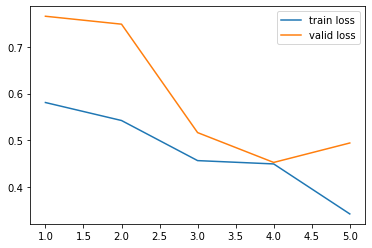

In [15]:
plt.plot([1, 2, 3, 4, 5], [0.58077, 0.54235, 0.45668, 0.44958, 0.34280], label="train loss")
plt.plot([1, 2, 3, 4, 5], [0.76508, 0.74814, 0.51650, 0.45276, 0.49432], label="valid loss")
plt.legend()
plt.show()